In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# 랜덤시드
np.random.seed(5)

#4분의 4박자
N = 4 

# loss 함수 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# training data set만들기
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)
	
# 훈련할 악보데이터 만들기
notes1 = ['Note' , 'Rest']
notes2 = ['Dur:Whole' , 'Dur:Half' , 'Dur:4th' , 'Dur:8th' , 'Dur:16th' , 'Dur:32nd']
notes3 = ['Pos:' + str(i) for i in range(-12,9)] + ['Pos:b0' , 'Pos:#-3' , 'Pos:#-2' , 'Pos:#-1' , 'Pos:#1' , 'Pos:#2' , 'Pos:#4' , 'Pos:n-1' , 'Pos:n-2']
notes4 = ['Dur:Whole' , 'Dur:Half' , 'Dur:4th' , 'Dur:8th' , 'Dur:16th' , 'Dur:32nd']
notes5 = ['Stem=Up' , 'Stem=Down']
notes6 = ['Beam=First' , 'Beam=End']
notes7 = ['' , ',Dotted']
notes8 = ['' , '^']
notes9 = ['' , 'B']

In [3]:
all_cs = []

#여러 요소들을 조합하여 음표사전 만드는 데에 참조할 단어집합 만들기
for s2 in notes2:
    for s3 in notes7:
        for s4 in notes3:
            for s5 in notes8:
                for s6 in notes9:
                    cs = ('|Note|' + s2 + s3 + '|' + s4 + s5 + '|' + s6) #음표
                    all_cs = all_cs + [cs] #위에서의 악보데이터들의 가능한 경우의 수 조합
                    #print(cs) 
                
for s1 in notes4:
    for s2 in notes7:
        cs = ('|Rest|' + s1 + s2) #쉼표 데이터들의 조합
        all_cs = all_cs + [cs]
        #print(cs) 

all_cs2 = []
for s in all_cs:
    if s[len(s)-1] == '|': #|가 끝에오는 경우 제거
        s = s[:-1]
    all_cs2.append(s)
all_cs = all_cs2
    
#음표사전 만들기 
idx = [idx for idx in range(0,len(all_cs))]
idx2code = dict(zip(idx , all_cs))
code2idx = dict(zip(all_cs , idx))


In [4]:
len(all_cs) , len(idx2code) , len(code2idx)

(1452, 1452, 1452)

In [5]:
import codecs
from bs4 import BeautifulSoup

#트레이닝할 악보 읽어오기(가요 '목로주점'외 10곡)
fp = codecs.open("NOTES.txt", "r")
lines = fp.readlines()
fp.close()

In [6]:
# 전처리하기 
all_lines = [] 

for str1 in lines:
    if not bool(str1.find('Bar')+1) and not bool(str1.find('Chord')+1):
        str1 = str1.replace("\n","")
        str1 = str1.replace("Stem=Up,","")
        str1 = str1.replace("Stem=Down,","")
        str1 = str1.replace("Opts:Beam=First","B")
        str1 = str1.replace("|Opts:Beam=End","")        
        str1 = str1.replace("Opts:Beam","B")    
        str1 = str1.replace(",Slur","")                
        str1 = str1.replace("|Opts:Stem=Up","")  
        str1 = str1.replace("|Opts:Stem=Down","")  
        str1 = str1.replace(",Triplet=First","")     
        str1 = str1.replace(",Triplet=End","")
        str1 = str1.replace(",Triplet","") 
        all_lines.append(str1) #불필요한 triplet 과 stem은 생략, Beam은 B로 대체
        #print(str1) 

In [7]:
#LSTM에 넣을 재료 만들기
seq = all_lines
dataset = seq2dataset(seq, window_size = 3) #(문제, 답) 형식
#처음부터 끝까지 악보를 읽으면서 3개 제시 => 다음의 한 개를 맞추도록 모델 학습
print(dataset.shape) #데이터의 개수 > 사전의 크기, 향상을 위해서는 사전의 크기를 늘려야 함

(3064, 4)


In [8]:
#input / target 설정하기
max_idx_value = len(idx2code)-1
x_train = dataset[:,0:3]
y_train = dataset[:,3]

#입력값 정규화
x_train = x_train / float(max_idx_value)

#데이터건수*time step*1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#one-hot encoding
y_train = np_utils.to_categorical(y_train)
one_hot_vec_size = y_train.shape[1]

x_train.shape , y_train.shape , one_hot_vec_size

((3064, 3, 1), (3064, 1451), 1451)

In [9]:
#모델 설계
model = Sequential()
model.add(LSTM(128, input_shape = (3, 1)))  #128 메모리 셀의 크기, time step == 3
model.add(Dense(one_hot_vec_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#1451개의 확률값을 아웃풋으로 출력
#loss function
history = LossHistory()
history.init()

#모델 학습시작
model.fit(x_train, y_train, epochs=1000, batch_size=14, verbose=2, callbacks=[history])

Epoch 1/1000
 - 1s - loss: 5.8442 - accuracy: 0.0251
Epoch 2/1000
 - 1s - loss: 5.1938 - accuracy: 0.0281
Epoch 3/1000
 - 1s - loss: 5.1553 - accuracy: 0.0326
Epoch 4/1000
 - 1s - loss: 5.1426 - accuracy: 0.0290
Epoch 5/1000
 - 1s - loss: 5.1370 - accuracy: 0.0310
Epoch 6/1000
 - 1s - loss: 5.1315 - accuracy: 0.0304
Epoch 7/1000
 - 1s - loss: 5.1140 - accuracy: 0.0424
Epoch 8/1000
 - 1s - loss: 5.0485 - accuracy: 0.0437
Epoch 9/1000
 - 1s - loss: 4.9787 - accuracy: 0.0401
Epoch 10/1000
 - 1s - loss: 4.9414 - accuracy: 0.0405
Epoch 11/1000
 - 1s - loss: 4.9233 - accuracy: 0.0411
Epoch 12/1000
 - 1s - loss: 4.9006 - accuracy: 0.0431
Epoch 13/1000
 - 1s - loss: 4.8811 - accuracy: 0.0444
Epoch 14/1000
 - 1s - loss: 4.8613 - accuracy: 0.0460
Epoch 15/1000
 - 1s - loss: 4.8386 - accuracy: 0.0516
Epoch 16/1000
 - 1s - loss: 4.8038 - accuracy: 0.0561
Epoch 17/1000
 - 1s - loss: 4.7749 - accuracy: 0.0617
Epoch 18/1000
 - 1s - loss: 4.7436 - accuracy: 0.0604
Epoch 19/1000
 - 1s - loss: 4.7059 - 

Epoch 152/1000
 - 1s - loss: 2.6950 - accuracy: 0.2830
Epoch 153/1000
 - 1s - loss: 2.6885 - accuracy: 0.2836
Epoch 154/1000
 - 1s - loss: 2.6818 - accuracy: 0.2849
Epoch 155/1000
 - 1s - loss: 2.6715 - accuracy: 0.2813
Epoch 156/1000
 - 1s - loss: 2.6727 - accuracy: 0.2875
Epoch 157/1000
 - 1s - loss: 2.6664 - accuracy: 0.2820
Epoch 158/1000
 - 1s - loss: 2.6580 - accuracy: 0.2833
Epoch 159/1000
 - 1s - loss: 2.6547 - accuracy: 0.2856
Epoch 160/1000
 - 1s - loss: 2.6505 - accuracy: 0.2895
Epoch 161/1000
 - 1s - loss: 2.6382 - accuracy: 0.2888
Epoch 162/1000
 - 1s - loss: 2.6264 - accuracy: 0.2839
Epoch 163/1000
 - 1s - loss: 2.6211 - accuracy: 0.2950
Epoch 164/1000
 - 1s - loss: 2.6171 - accuracy: 0.2888
Epoch 165/1000
 - 1s - loss: 2.6166 - accuracy: 0.2908
Epoch 166/1000
 - 1s - loss: 2.6067 - accuracy: 0.2918
Epoch 167/1000
 - 1s - loss: 2.5965 - accuracy: 0.2957
Epoch 168/1000
 - 1s - loss: 2.5894 - accuracy: 0.2872
Epoch 169/1000
 - 1s - loss: 2.5875 - accuracy: 0.2993
Epoch 170/

Epoch 301/1000
 - 1s - loss: 2.0647 - accuracy: 0.3884
Epoch 302/1000
 - 1s - loss: 2.0697 - accuracy: 0.3881
Epoch 303/1000
 - 1s - loss: 2.0632 - accuracy: 0.3845
Epoch 304/1000
 - 1s - loss: 2.0694 - accuracy: 0.3832
Epoch 305/1000
 - 1s - loss: 2.0606 - accuracy: 0.3851
Epoch 306/1000
 - 1s - loss: 2.0522 - accuracy: 0.3956
Epoch 307/1000
 - 1s - loss: 2.0583 - accuracy: 0.3825
Epoch 308/1000
 - 1s - loss: 2.0509 - accuracy: 0.3903
Epoch 309/1000
 - 1s - loss: 2.0536 - accuracy: 0.3897
Epoch 310/1000
 - 1s - loss: 2.0393 - accuracy: 0.3988
Epoch 311/1000
 - 1s - loss: 2.0421 - accuracy: 0.3910
Epoch 312/1000
 - 1s - loss: 2.0320 - accuracy: 0.3985
Epoch 313/1000
 - 1s - loss: 2.0377 - accuracy: 0.3881
Epoch 314/1000
 - 1s - loss: 2.0399 - accuracy: 0.3930
Epoch 315/1000
 - 1s - loss: 2.0405 - accuracy: 0.3959
Epoch 316/1000
 - 1s - loss: 2.0411 - accuracy: 0.3881
Epoch 317/1000
 - 1s - loss: 2.0173 - accuracy: 0.3952
Epoch 318/1000
 - 1s - loss: 2.0311 - accuracy: 0.3939
Epoch 319/

Epoch 450/1000
 - 1s - loss: 1.7300 - accuracy: 0.4582
Epoch 451/1000
 - 1s - loss: 1.7274 - accuracy: 0.4579
Epoch 452/1000
 - 1s - loss: 1.7281 - accuracy: 0.4602
Epoch 453/1000
 - 1s - loss: 1.7444 - accuracy: 0.4517
Epoch 454/1000
 - 1s - loss: 1.7307 - accuracy: 0.4569
Epoch 455/1000
 - 1s - loss: 1.7275 - accuracy: 0.4605
Epoch 456/1000
 - 1s - loss: 1.7318 - accuracy: 0.4507
Epoch 457/1000
 - 1s - loss: 1.7259 - accuracy: 0.4537
Epoch 458/1000
 - 1s - loss: 1.7242 - accuracy: 0.4641
Epoch 459/1000
 - 1s - loss: 1.7299 - accuracy: 0.4579
Epoch 460/1000
 - 1s - loss: 1.7288 - accuracy: 0.4517
Epoch 461/1000
 - 1s - loss: 1.7143 - accuracy: 0.4589
Epoch 462/1000
 - 1s - loss: 1.7132 - accuracy: 0.4602
Epoch 463/1000
 - 1s - loss: 1.7112 - accuracy: 0.4648
Epoch 464/1000
 - 1s - loss: 1.7198 - accuracy: 0.4595
Epoch 465/1000
 - 1s - loss: 1.7208 - accuracy: 0.4510
Epoch 466/1000
 - 1s - loss: 1.7196 - accuracy: 0.4608
Epoch 467/1000
 - 1s - loss: 1.7019 - accuracy: 0.4683
Epoch 468/

Epoch 599/1000
 - 1s - loss: 1.5163 - accuracy: 0.5059
Epoch 600/1000
 - 1s - loss: 1.5178 - accuracy: 0.5003
Epoch 601/1000
 - 1s - loss: 1.5161 - accuracy: 0.5078
Epoch 602/1000
 - 1s - loss: 1.5156 - accuracy: 0.5033
Epoch 603/1000
 - 1s - loss: 1.5146 - accuracy: 0.5046
Epoch 604/1000
 - 1s - loss: 1.5323 - accuracy: 0.5026
Epoch 605/1000
 - 1s - loss: 1.5237 - accuracy: 0.4951
Epoch 606/1000
 - 1s - loss: 1.5180 - accuracy: 0.4984
Epoch 607/1000
 - 1s - loss: 1.5051 - accuracy: 0.5033
Epoch 608/1000
 - 1s - loss: 1.5321 - accuracy: 0.4980
Epoch 609/1000
 - 1s - loss: 1.5164 - accuracy: 0.5104
Epoch 610/1000
 - 1s - loss: 1.5163 - accuracy: 0.5049
Epoch 611/1000
 - 1s - loss: 1.5020 - accuracy: 0.5117
Epoch 612/1000
 - 1s - loss: 1.5036 - accuracy: 0.5095
Epoch 613/1000
 - 1s - loss: 1.5095 - accuracy: 0.5069
Epoch 614/1000
 - 1s - loss: 1.5094 - accuracy: 0.5059
Epoch 615/1000
 - 1s - loss: 1.5216 - accuracy: 0.4967
Epoch 616/1000
 - 1s - loss: 1.5091 - accuracy: 0.5082
Epoch 617/

Epoch 748/1000
 - 1s - loss: 1.3936 - accuracy: 0.5304
Epoch 749/1000
 - 1s - loss: 1.3686 - accuracy: 0.5431
Epoch 750/1000
 - 1s - loss: 1.3707 - accuracy: 0.5388
Epoch 751/1000
 - 1s - loss: 1.3664 - accuracy: 0.5460
Epoch 752/1000
 - 1s - loss: 1.3649 - accuracy: 0.5424
Epoch 753/1000
 - 1s - loss: 1.3802 - accuracy: 0.5369
Epoch 754/1000
 - 1s - loss: 1.3772 - accuracy: 0.5379
Epoch 755/1000
 - 1s - loss: 1.3946 - accuracy: 0.5343
Epoch 756/1000
 - 1s - loss: 1.3723 - accuracy: 0.5369
Epoch 757/1000
 - 1s - loss: 1.3692 - accuracy: 0.5395
Epoch 758/1000
 - 1s - loss: 1.3613 - accuracy: 0.5441
Epoch 759/1000
 - 1s - loss: 1.3633 - accuracy: 0.5382
Epoch 760/1000
 - 1s - loss: 1.3677 - accuracy: 0.5421
Epoch 761/1000
 - 1s - loss: 1.3699 - accuracy: 0.5359
Epoch 762/1000
 - 1s - loss: 1.3581 - accuracy: 0.5444
Epoch 763/1000
 - 1s - loss: 1.3791 - accuracy: 0.5369
Epoch 764/1000
 - 1s - loss: 1.3756 - accuracy: 0.5385
Epoch 765/1000
 - 1s - loss: 1.3558 - accuracy: 0.5401
Epoch 766/

Epoch 897/1000
 - 1s - loss: 1.2571 - accuracy: 0.5679
Epoch 898/1000
 - 1s - loss: 1.2568 - accuracy: 0.5715
Epoch 899/1000
 - 1s - loss: 1.2884 - accuracy: 0.5525
Epoch 900/1000
 - 1s - loss: 1.2557 - accuracy: 0.5617
Epoch 901/1000
 - 1s - loss: 1.2581 - accuracy: 0.5623
Epoch 902/1000
 - 1s - loss: 1.2681 - accuracy: 0.5578
Epoch 903/1000
 - 1s - loss: 1.2622 - accuracy: 0.5669
Epoch 904/1000
 - 1s - loss: 1.2618 - accuracy: 0.5702
Epoch 905/1000
 - 1s - loss: 1.2700 - accuracy: 0.5617
Epoch 906/1000
 - 1s - loss: 1.2607 - accuracy: 0.5682
Epoch 907/1000
 - 1s - loss: 1.2486 - accuracy: 0.5610
Epoch 908/1000
 - 1s - loss: 1.2735 - accuracy: 0.5565
Epoch 909/1000
 - 1s - loss: 1.2657 - accuracy: 0.5548
Epoch 910/1000
 - 1s - loss: 1.2439 - accuracy: 0.5656
Epoch 911/1000
 - 1s - loss: 1.2531 - accuracy: 0.5796
Epoch 912/1000
 - 1s - loss: 1.2393 - accuracy: 0.5760
Epoch 913/1000
 - 1s - loss: 1.2709 - accuracy: 0.5545
Epoch 914/1000
 - 1s - loss: 1.2704 - accuracy: 0.5698
Epoch 915/

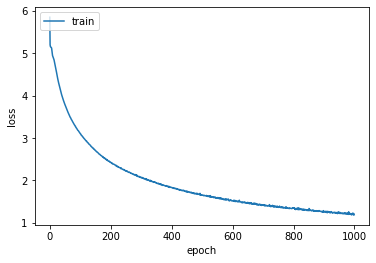

In [10]:
# 트레이닝 과정
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [11]:
# 모델평가
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

3064/3064 [==============================] - 0s 59us/step
accuracy: 61.98%


In [12]:
#작곡시작
pred_count = 200 #생성할 note(또는 rest)의 수
    
seq_in = ['|Note|Dur:4th|Pos:-4', '|Note|Dur:4th|Pos:-2', '|Note|Dur:Half,Dotted|Pos:-2']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 3, 1))
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)


full song prediction :  ['|Note|Dur:4th|Pos:-4', '|Note|Dur:4th|Pos:-2', '|Note|Dur:Half,Dotted|Pos:-2', '|Note|Dur:Half|Pos:-5', '|Note|Dur:4th|Pos:-3', '|Rest|Dur:8th', '|Note|Dur:8th|Pos:-4', '|Note|Dur:4th|Pos:-4', '|Note|Dur:4th|Pos:-2', '|Note|Dur:8th|Pos:-6|B', '|Note|Dur:16th|Pos:-4|B', '|Note|Dur:32nd|Pos:-2^', '|Rest|Dur:16th,Dotted', '|Note|Dur:8th,Dotted|Pos:#1^|B', '|Note|Dur:8th|Pos:-1', '|Note|Dur:32nd|Pos:-3', '|Note|Dur:16th,Dotted|Pos:-2', '|Note|Dur:8th|Pos:-2|B', '|Note|Dur:32nd|Pos:-1|B', '|Note|Dur:8th|Pos:-1|B', '|Note|Dur:8th,Dotted|Pos:-1', '|Rest|Dur:16th', '|Note|Dur:8th,Dotted|Pos:-3^|B', '|Note|Dur:32nd|Pos:-2', '|Note|Dur:32nd|Pos:-1|B', '|Note|Dur:4th|Pos:-3^', '|Note|Dur:Half|Pos:-3', '|Note|Dur:8th|Pos:-1|B', '|Note|Dur:16th,Dotted|Pos:1|B', '|Note|Dur:16th|Pos:-2', '|Rest|Dur:16th', '|Note|Dur:16th|Pos:-2|B', '|Note|Dur:16th,Dotted|Pos:-1', '|Note|Dur:8th|Pos:-1^|B', '|Note|Dur:32nd|Pos:b0^', '|Note|Dur:8th|Pos:-1|B', '|Note|Dur:8th|Pos:-2', '|Note|Dur

In [13]:
nwc = open('창작곡.txt', 'w')

for item in seq_out:
  nwc.write("%s\n" % item)

nwc.close()

# NWC format으로 다시 만들기 
import re
fp = codecs.open("창작곡.txt", "r")
lines = fp.readlines()
len_sum = 0 
length = 0 
bar = 0.25 * N   #마디 1개의 길이
update_lines = []
over_length = 0 
cnt = 0 
fp.close()

In [14]:
for note in lines:
    
    cnt += 1
    need_special = False
    resid_special = False
    note = note.replace('\n' , '')
    note_comp = note.split('|')
    
    #길이추출
    matching = [s for s in note_comp if "Dur" in s][0].split(":")[1]
    
    #마디를 씌우기 위한 누적계산
    if matching.find('Half')+1:
        length = 0.5
    elif matching.find('Whole')+1:
        length = 1
    else:        
        length = 1/int(re.findall('\d+', matching)[0])
        
    if matching.find('Dotted')+1:
        length = length + length/2
        
    len_sum += length
    
    #1이하인 경우는 정상이므로 추가한다. 
    if len_sum <= 1:
        update_lines.append(note)
        print(note , length , len_sum)
        
        if len_sum == 1:
            len_sum = 0 
            update_lines.append('|Bar')
            print('|Bar')
        
        #마지막 마디에서 완전하게 음표를 채운다. 
        if len(lines) == cnt:
            print('**********마지막 마디입니다.' , note , len_sum)
            need_len = 1 - len_sum
            
            if need_len > 0:
                
                #마지막 음표를 채운다. 
                if need_len == 0.75:
                    Dur_str = "Half,Dotted"
                elif need_len == 0.5:
                    Dur_str = "Half"
                elif need_len == 0.375:
                    Dur_str = "4th,Dotted"
                elif need_len == 0.25:
                    Dur_str = "4th"
                elif need_len == 0.1875:
                    Dur_str = "8th,Dotted"
                elif need_len == 0.125:
                    Dur_str = "8th"
                elif need_len == 0.09375:
                    Dur_str = "16th,Dotted"
                elif need_len == 0.0625:
                    Dur_str = "16th"
                elif need_len == 0.046875:
                    Dur_str = "32th,Dotted"
                elif need_len == 0.03125:
                    Dur_str = "32th"
                
                note_comp = note.split('|')
                index = [i for i, string in enumerate(note_comp) if "Dur" in string][0]
                Dur_str = "Dur:" + Dur_str
                
                note_comp[index] = Dur_str
                need_str = '|'.join(note_comp)
                
                #마지막 마디의 마지막 음표를 추가한다.(쉼표가 될 수도 있음)
                if Dur_str != "Dur:":
                    update_lines.append(need_str)
                    print("*" , need_str , need_len , 1.0)

            
    else:
        #길이가 over가 된 경우에는 음표를 2개로 쪼개고 가운데에 bar을 찍는다. 
        #Dur이 속한 위치와 길이를 알아낸다.(Dur를 수정해야 하기 때문에)
        note_comp = note.split('|')
        index = [i for i, string in enumerate(note_comp) if "Dur" in string][0]
        matching = [s for s in note_comp if "Dur" in s][0].split(":")[1]
        
        if "Whole" in matching:
            over_length = 1
        elif "Half" in matching:
            over_length = 0.5
        elif "4th" in matching:
            over_length = 1/4
        elif "8th" in matching:
            over_length = 1/8
        elif "16th" in matching:
            over_length = 1/16
        elif "32nd" in matching:
            over_length = 1/32
        else:
            over_length = 0
            
        if "Dotted" in matching:
            over_length = over_length + over_length/2
        
        #마디의 모자란 길이와 남는 길이를 알아내고 bar(마디)를 찍을 준비를 한다. 
        resid_len = len_sum - 1                 #다음 마디로 넘어갈 길이
        need_len = over_length - resid_len      #현재 마디에서 필요한 길이
        
        #마디의 남은 부분 채우기(현재마디의 여분) 
        if need_len == 0.75:
            Dur_str = "Half,Dotted"
        elif need_len == 0.5:
            Dur_str = "Half"
        elif need_len == 0.375:
            Dur_str = "4th,Dotted"
        elif need_len == 0.25:
            Dur_str = "4th"
        elif need_len == 0.1875:
            Dur_str = "8th,Dotted"
        elif need_len == 0.125:
            Dur_str = "8th"
        elif need_len == 0.09375:
            Dur_str = "16th,Dotted"
        elif need_len == 0.0625:
            Dur_str = "16th"
        elif need_len == 0.046875:
            Dur_str = "32th,Dotted"
        elif need_len == 0.03125:
            Dur_str = "32th"
        elif need_len == 0:
            Dur_str = ""
        else:
            #해당사항이 없으면 가장 가까운 음표를 찾아서 넣어준다.(이런 경우는 2개이상의 음표가 필요하다.)
            if need_len == 0.15625 or need_len == 0.625:
                need_special = True

            
        #마디의 over된 부분 채우기(다음 마디로 넘어감)
        if resid_len == 0.75:
            Dur_str2 = "Half,Dotted"
        elif resid_len == 0.5:
            Dur_str2 = "Half"
        elif resid_len == 0.375:
            Dur_str2 = "4th,Dotted"
        elif resid_len == 0.25:
            Dur_str2 = "4th"
        elif resid_len == 0.1875:
            Dur_str2 = "8th,Dotted"
        elif resid_len == 0.125:
            Dur_str2 = "8th"
        elif resid_len == 0.09375:
            Dur_str2 = "16th,Dotted"
        elif resid_len == 0.0625:
            Dur_str2 = "16th"
        elif resid_len == 0.046875:
            Dur_str2 = "32th,Dotted"
        elif resid_len == 0.03125:
            Dur_str2 = "32th"
        elif resid_len == 0:
            Dur_str2 = ""
        else:
            #해당사항이 없으면 가장 가까운 음표를 찾아서 넣어준다.
            resid_special = True
        
        #마디의 여분을 채우는 작업 ########################################1
        len_sum = len_sum - resid_len
        
        Dur_str = "Dur:" + Dur_str
        Dur_str2 = "Dur:" + Dur_str2 
        
        note_comp[index] = Dur_str
        need_str = '|'.join(note_comp)

        note_comp[index] = Dur_str2
        resid_str = '|'.join(note_comp)
        
        if Dur_str != "Dur:":
            update_lines.append(need_str)
            print("*" , need_str , need_len , len_sum)
            
        #마디가 맞지 않는 특별한 상황    
        if need_special == True:
            if need_len == 0.15625:    #8분음표와 32분음표를 추가 
                Dur_str = "Dur:8th"
                note_comp[index] = Dur_str
                need_str = '|'.join(note_comp)
                update_lines.append(need_str)
                print("**" , need_str , 1/8 , len_sum)
                
                Dur_str = "Dur:32nd"
                note_comp[index] = Dur_str
                need_str = '|'.join(note_comp)
                update_lines.append(need_str)
                print("**" , need_str , 1/32 , len_sum)
                
            if need_len == 0.625:      #이분음표와 8분음표를 추가
                Dur_str = "Dur:Half"
                note_comp[index] = Dur_str
                need_str = '|'.join(note_comp)
                update_lines.append(need_str)
                print("**" , need_str , 1/2 , len_sum)
                
                Dur_str = "Dur:8th"
                note_comp[index] = Dur_str
                need_str = '|'.join(note_comp)
                update_lines.append(need_str)
                print("**" , need_str , 1/8 , len_sum)
                
            # ....계속 추가하여 완벽하게 만든다. 

        #마디의 경계를 그려준다.(칸막이) ###############################################2
        update_lines.append('|Bar')
        print('|Bar') 

        #다음 마디로 넘어가는 부분을 그려준다. ##########################################3 
        len_sum = resid_len
        
        if Dur_str2 != "Dur:":
            update_lines.append(resid_str)
            print("*" , resid_str , resid_len , len_sum)

        #음표길이 문자열을 초기화한다. ####################################
        Dur_str = ""
        Dur_str2 = ""        



|Note|Dur:4th|Pos:-4 0.25 0.25
|Note|Dur:4th|Pos:-2 0.25 0.5
* |Note|Dur:Half|Pos:-2 0.5 1.0
|Bar
* |Note|Dur:4th|Pos:-2 0.25 0.25
|Note|Dur:Half|Pos:-5 0.5 0.75
|Note|Dur:4th|Pos:-3 0.25 1.0
|Bar
|Rest|Dur:8th 0.125 0.125
|Note|Dur:8th|Pos:-4 0.125 0.25
|Note|Dur:4th|Pos:-4 0.25 0.5
|Note|Dur:4th|Pos:-2 0.25 0.75
|Note|Dur:8th|Pos:-6|B 0.125 0.875
|Note|Dur:16th|Pos:-4|B 0.0625 0.9375
|Note|Dur:32nd|Pos:-2^ 0.03125 0.96875
* |Rest|Dur:32th 0.03125 1.0
|Bar
* |Rest|Dur:16th 0.0625 0.0625
|Note|Dur:8th,Dotted|Pos:#1^|B 0.1875 0.25
|Note|Dur:8th|Pos:-1 0.125 0.375
|Note|Dur:32nd|Pos:-3 0.03125 0.40625
|Note|Dur:16th,Dotted|Pos:-2 0.09375 0.5
|Note|Dur:8th|Pos:-2|B 0.125 0.625
|Note|Dur:32nd|Pos:-1|B 0.03125 0.65625
|Note|Dur:8th|Pos:-1|B 0.125 0.78125
|Note|Dur:8th,Dotted|Pos:-1 0.1875 0.96875
* |Rest|Dur:32th 0.03125 1.0
|Bar
* |Rest|Dur:32th 0.03125 0.03125
|Note|Dur:8th,Dotted|Pos:-3^|B 0.1875 0.21875
|Note|Dur:32nd|Pos:-2 0.03125 0.25
|Note|Dur:32nd|Pos:-1|B 0.03125 0.28125
|Note|Dur

In [15]:
#Beam(잇단음표)에 해당하는 문자열을 넣어준다. #########################################
start = False
end = False
cnt = 0 

for uline in update_lines:
    cnt += 1
    
    if 'Bar' in uline:
        start = False
        before_line = update_lines[cnt-2]
        
        if 'BF' in before_line:
            before_line = before_line.replace('|BF' , '')
            update_lines[cnt-2] = before_line
        elif 'BM' in before_line:
            before_line = before_line.replace('BM' , 'BE')
            update_lines[cnt-2] = before_line
    
    if uline[-1] == "B" and start == False:
        start = True
        uline = uline.replace('B' , 'BF')
        update_lines[cnt-1] = uline
    elif start == True and uline[-1] == "B":
        uline = uline.replace('B' , 'BM')
        update_lines[cnt-1] = uline
    elif start == True and uline[-1] != "B":
        uline = uline + '|BE'
        end = True
        start = False
        update_lines[cnt-1] = uline

#마지막 라인도 같은 방법으로 수정함.
last_line = update_lines[len(update_lines)-1]
last_line

if 'BF' in last_line:
    last_line = last_line.replace('|BF' , '')
    update_lines[len(update_lines)-1] = last_line
elif 'BM' in last_line:
    last_line = last_line.replace('BM' , 'BE')
    update_lines[len(update_lines)-1] = last_line
    
#print(update_lines)

cnt = 0 

#특정 작곡프로그램의 format에 맞게 수정함. 
for uline in update_lines:
    cnt += 1
    
    if 'Pos' in uline:
        #음의 높이를 구하기(음의 높이에 따라 stem의 방향이 바뀐다.)
        uline_comp = uline.split('|')
        index = [i for i, string in enumerate(uline_comp) if "Pos" in string][0]
        matching = [s for s in uline_comp if "Pos" in s][0].split(":")[1]
        pos = int(re.findall('[+-]*\d+', matching)[0])
        
        if pos < 0:
            direct = "Opts:Stem=Up,"
        else:
            direct = "Opts:Stem=Down,"
            
    else:
        direct = ""

    uline = uline.replace('BE',direct + 'Beam=End')
    uline = uline.replace('BF',direct + 'Beam=First')
    uline = uline.replace('BM','Beam')

    update_lines[cnt-1] = uline 
    
    print(uline , pos) 

#최종 악보만들기 

preface = ['!NoteWorthyComposer(2.75)' , '|Clef|Type:Treble' , '|TimeSig|Signature:4/4' , '|Tempo|Tempo:128|Pos:6','|Bar']
postface = ['!NoteWorthyComposer-End']        
update_lines = preface + update_lines + postface

nwc = open('창작곡.nwctxt', 'w')

for uline in update_lines:
  nwc.write("%s\n" % uline)

nwc.close()

|Note|Dur:4th|Pos:-4 -4
|Note|Dur:4th|Pos:-2 -2
|Note|Dur:Half|Pos:-2 -2
|Bar -2
|Note|Dur:4th|Pos:-2 -2
|Note|Dur:Half|Pos:-5 -5
|Note|Dur:4th|Pos:-3 -3
|Bar -3
|Rest|Dur:8th -3
|Note|Dur:8th|Pos:-4 -4
|Note|Dur:4th|Pos:-4 -4
|Note|Dur:4th|Pos:-2 -2
|Note|Dur:8th|Pos:-6|Opts:Stem=Up,Beam=First -6
|Note|Dur:16th|Pos:-4|Beam -4
|Note|Dur:32nd|Pos:-2^|Opts:Stem=Up,Beam=End -2
|Rest|Dur:32th -2
|Bar -2
|Rest|Dur:16th -2
|Note|Dur:8th,Dotted|Pos:#1^|Opts:Stem=Down,Beam=First 1
|Note|Dur:8th|Pos:-1|Opts:Stem=Up,Beam=End -1
|Note|Dur:32nd|Pos:-3 -3
|Note|Dur:16th,Dotted|Pos:-2 -2
|Note|Dur:8th|Pos:-2|Opts:Stem=Up,Beam=First -2
|Note|Dur:32nd|Pos:-1|Beam -1
|Note|Dur:8th|Pos:-1|Beam -1
|Note|Dur:8th,Dotted|Pos:-1|Opts:Stem=Up,Beam=End -1
|Rest|Dur:32th -1
|Bar -1
|Rest|Dur:32th -1
|Note|Dur:8th,Dotted|Pos:-3^|Opts:Stem=Up,Beam=First -3
|Note|Dur:32nd|Pos:-2|Opts:Stem=Up,Beam=End -2
|Note|Dur:32nd|Pos:-1|Opts:Stem=Up,Beam=First -1
|Note|Dur:4th|Pos:-3^|Opts:Stem=Up,Beam=End -3
|Bar -3
|Note|Du